In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/masksforwordclouds/twitter_mask2.png
/kaggle/input/masksforwordclouds/twitter_mask4.jpg
/kaggle/input/masksforwordclouds/twitter_mask3.jpg
/kaggle/input/masksforwordclouds/book-logo-1.jpg
/kaggle/input/masksforwordclouds/twitter_mask.png
/kaggle/input/masksforwordclouds/wordcloud-man.png
/kaggle/input/masksforwordclouds/twitter_mask3.png
/kaggle/input/sms-spam-collection-dataset/spam.csv


In [2]:
# Importing necessary libraries for data manipulation and analysis
import re                   # Regular expressions for text processing
import string               # String operations like punctuation removal
import numpy as np          # Numerical computing library
import random               # Random number generation
import pandas as pd         # Data manipulation library

# Visualization libraries
import matplotlib.pyplot as plt  # Basic plotting library
import seaborn as sns            # Statistical data visualization

# Plotly for interactive plots
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# Collections for handling collections of data
from collections import Counter

# PIL for image processing, WordCloud for generating word clouds
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NLTK (Natural Language Toolkit) for basic NLP tasks
import nltk
from nltk.corpus import stopwords  # Stopwords are common words that are often removed in NLP tasks
from nltk.tokenize import word_tokenize  # Tokenization: breaking text into words or sentences

# tqdm for progress bars
from tqdm import tqdm

# Operating system interaction
import os

# spaCy for advanced NLP tasks such as named entity recognition and part-of-speech tagging
import spacy

# Keras for building deep learning models
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM,               # Long Short-Term Memory (LSTM) for sequential data
                          Embedding,          # Word embeddings for representing words as vectors
                          BatchNormalization, # Normalization technique to stabilize learning
                          Dense,              # Fully connected layer
                          TimeDistributed,    # Apply a layer to each time step in a sequence
                          Dropout,            # Regularization technique to prevent overfitting
                          Bidirectional,      # Bidirectional LSTM to capture context from both directions
                          Flatten,            # Flatten layer for reshaping data
                          GlobalMaxPool1D)    # Pooling layer for reducing dimensionality

from keras.preprocessing.text import Tokenizer         # Tokenization utility in Keras
from keras.preprocessing.sequence import pad_sequences # Padding sequences to ensure uniform length
from keras.layers.embeddings import Embedding          # Embedding layer for word representation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau  # Callbacks for model training
from keras.optimizers import Adam                       # Optimizer for gradient descent

# sklearn for machine learning utilities
from sklearn.metrics import (
    precision_score,       # Precision metric: TP / (TP + FP)
    recall_score,          # Recall metric: TP / (TP + FN)
    f1_score,              # F1-score metric: harmonic mean of precision and recall
    classification_report, # Classification report with precision, recall, and F1-score
    accuracy_score         # Accuracy metric: (TP + TN) / (TP + TN + FP + FN)
)

# Detailed explanations have been added for each import statement, especially focusing on NLP-related concepts and libraries.


## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">Table of Content</p>

* [1. Loading Data 💎](#1)
* [2. EDA 📊](#2)
* [3. Data Preprocessing ⚙️](#3)
    * [3.1 Cleaning the corpus 🛠](#3.1)
    * [3.2 Stemming 🛠](#3.2)
    * [3.3 All together 🛠](#3.3)
    * [3.4 Target encoding 🛠](#3.4)
* [4. Tokens visualization 📊](#4)
* [5. Vectorization](#5)
    * [5.1 Tunning CountVectorizer](#5.1)
    * [5.2 TF-IDF](#5.2)
    * [5.3 Word Embeddings: GloVe](#5.3)
* [6. Modeling](#6)
    * [6.1 Naive Bayes DTM](#6.1)
    * [6.2 Naive Bayes TF-IDF](#6.2)
    * [6.3 XGBoost](#6.3)
* [7. LSTM](#7)
* [8. BERT](#8)


<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">1. Loading Data 💎</p>



In [3]:
# Defining color variables for use in visualizations
primary_blue = "#496595"      # A shade of blue
primary_blue2 = "#85a1c1"     # Another shade of blue
primary_blue3 = "#3f4d63"     # Yet another shade of blue
primary_grey = "#c6ccd8"      # A shade of grey
primary_black = "#202022"     # A shade of black
primary_bgcolor = "#f4f0ea"   # Background color

# Extracting a primary green color from the Plotly qualitative color palette
primary_green = px.colors.qualitative.Plotly[2]


In [4]:
# Reading a CSV file into a pandas DataFrame
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding="latin-1")
# Dropping any rows with missing values (NaN) from the DataFrame
df = df.dropna(how="any", axis=1)

# Renaming columns for clarity
df.columns = ['target', 'message']

# Displaying the first few rows of the DataFrame
df.head()


,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# Adding a new column 'message_len' to the DataFrame
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')))

# Displaying the first few rows of the DataFrame with the new column
df.head()


,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [6]:
# Computing the maximum value of the 'message_len' column
max(df['message_len'])


171

<a id='2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. EDA 📊</p>

Now we are going to take a look about the target distribution and the messages length.

In [7]:
# Grouping the DataFrame by the 'target' column and calculating the count of each unique value
# The result is an aggregation of counts for each unique value in the 'target' column
balance_counts = df.groupby('target')['target'].agg('count').values

# Displaying the aggregated counts
balance_counts


array([4825,  747])

In [8]:
# Creating a new Figure object
fig = go.Figure()

# Adding a bar trace for the 'ham' class
fig.add_trace(go.Bar(
    x=['ham'],                          # x-axis: label for the 'ham' class
    y=[balance_counts[0]],              # y-axis: count of the 'ham' class
    name='ham',                         # Trace name
    text=[balance_counts[0]],           # Text to be displayed on the bars
    textposition='auto',                # Positioning of text
    marker_color=primary_blue           # Bar color for the 'ham' class
))

# Adding a bar trace for the 'spam' class
fig.add_trace(go.Bar(
    x=['spam'],                         # x-axis: label for the 'spam' class
    y=[balance_counts[1]],              # y-axis: count of the 'spam' class
    name='spam',                        # Trace name
    text=[balance_counts[1]],           # Text to be displayed on the bars
    textposition='auto',                # Positioning of text
    marker_color=primary_grey           # Bar color for the 'spam' class
))

# Updating layout settings for the figure
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'  # Title of the plot
)

# Displaying the figure
fig.show()


As we can see, the classes are imbalanced, so we can consider using some kind of resampling.

In [9]:
# Filtering the DataFrame to get only 'ham' messages and counting the occurrences of each message length
ham_df = df[df['target'] == 'ham']['message_len'].value_counts().sort_index()

# Filtering the DataFrame to get only 'spam' messages and counting the occurrences of each message length
spam_df = df[df['target'] == 'spam']['message_len'].value_counts().sort_index()

# Creating a new Figure object
fig = go.Figure()

# Adding a scatter trace for the 'ham' class
fig.add_trace(go.Scatter(
    x=ham_df.index,                     # x-axis: message length
    y=ham_df.values,                    # y-axis: count of messages with that length
    name='ham',                         # Trace name
    fill='tozeroy',                     # Fill area below the curve
    marker_color=primary_blue           # Line color for the 'ham' class
))

# Adding a scatter trace for the 'spam' class
fig.add_trace(go.Scatter(
    x=spam_df.index,                    # x-axis: message length
    y=spam_df.values,                   # y-axis: count of messages with that length
    name='spam',                        # Trace name
    fill='tozeroy',                     # Fill area below the curve
    marker_color=primary_grey           # Line color for the 'spam' class
))

# Updating layout settings for the figure
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>',  # Title of the plot
)

# Setting the range of x-axis
fig.update_xaxes(range=[0, 70])

# Displaying the figure
fig.show()


As we can see, the `ham` message length tend to be lower than `spam` message length.

# <a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">3. Data Pre-processing 🛠</p>



<a id='3.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.1 Cleaning the corpus 🛠</p>

In [56]:

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove links, remove punctuation,
    and remove words containing numbers.'''
    # Convert text to lowercase
    text = str(text).lower()
    
    # Remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    
    # Remove links (URLs)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub('<.*?>+', '', text)
    
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    # Remove newline characters
    text = re.sub('\n', '', text)
    
    # Remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    
    return text


In [11]:
# Applying the clean_text function to the 'message' column of the DataFrame
df['message_clean'] = df['message'].apply(clean_text)

# Displaying the first few rows of the DataFrame with the new 'message_clean' column
df.head()


,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


### Stopwords


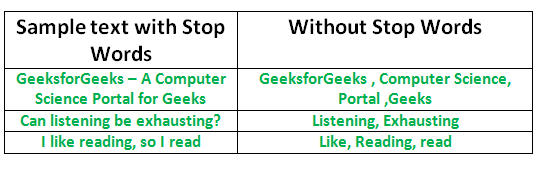

In [12]:
# Adding additional stopwords to the default English stopwords list
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

# Defining a function to remove stopwords from text
def remove_stopwords(text):
    # Split the text into words and join them back if they are not in the stop_words list
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

# Applying the remove_stopwords function to the 'message_clean' column of the DataFrame
df['message_clean'] = df['message_clean'].apply(remove_stopwords)

# Displaying the first few rows of the DataFrame with the stopwords removed from the 'message_clean' column
df.head()


,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goes usf lives around though


<a id='3.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.2 Stemming 🛠</p>

### Stemming/ Lematization


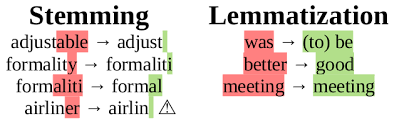

As far as the meaning of the words is not important for this study, we will focus on stemming rather than lemmatization.



In [13]:
# Importing the Snowball Stemmer from NLTK
import nltk
from nltk.stem import SnowballStemmer

# Initializing the Snowball Stemmer for English
stemmer = nltk.SnowballStemmer("english")

# Defining a function to perform stemming on text
def stemm_text(text):
    # Split the text into words, stem each word, and join them back
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text


In [14]:
# Applying the stemm_text function to the 'message_clean' column of the DataFrame
df['message_clean'] = df['message_clean'].apply(stemm_text)

# Displaying the first few rows of the DataFrame with the stemmed text in the 'message_clean' column
df.head()


,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


<a id='3.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.3 All together 🛠</p>

In [15]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

In [16]:
df['message_clean'] = df['message_clean'].apply(preprocess_data)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say ear hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


<a id='3.4'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.4 Target encoding 🛠</p>

In [17]:
from sklearn.preprocessing import LabelEncoder

# Initialize a LabelEncoder object
le = LabelEncoder()

# Fit the LabelEncoder to the 'target' column in the DataFrame
le.fit(df['target'])

# Transform the 'target' column into encoded labels
df['target_encoded'] = le.transform(df['target'])

# Display the first few rows of the DataFrame
df.head()


,target,message,message_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,11,dun say ear hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. Tokens visualization 📊</p>

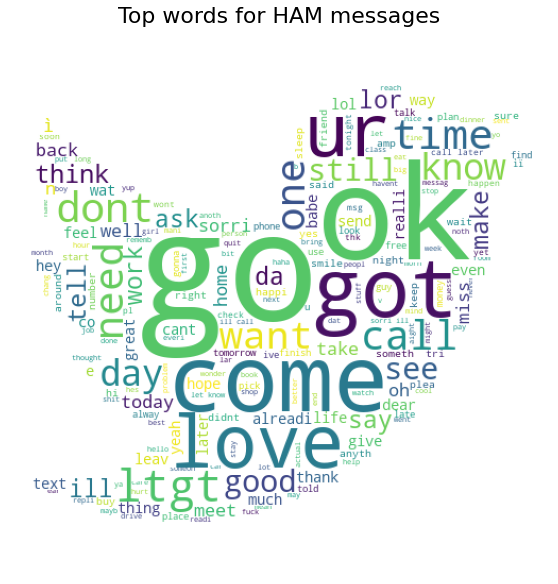

In [18]:
# Load the custom Twitter mask image
twitter_mask = np.array(Image.open('/kaggle/input/masksforwordclouds/twitter_mask3.jpg'))

# Initialize a WordCloud object with specified parameters
wc = WordCloud(
    background_color='white',  # Background color of the word cloud
    max_words=200,              # Maximum number of words to display
    mask=twitter_mask           # Mask image to shape the word cloud
)

# Generate the word cloud using 'ham' messages
wc.generate(' '.join(text for text in df.loc[df['target'] == 'ham', 'message_clean']))

# Plot the word cloud
plt.figure(figsize=(18,10))
plt.title('Top words for HAM messages', fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()


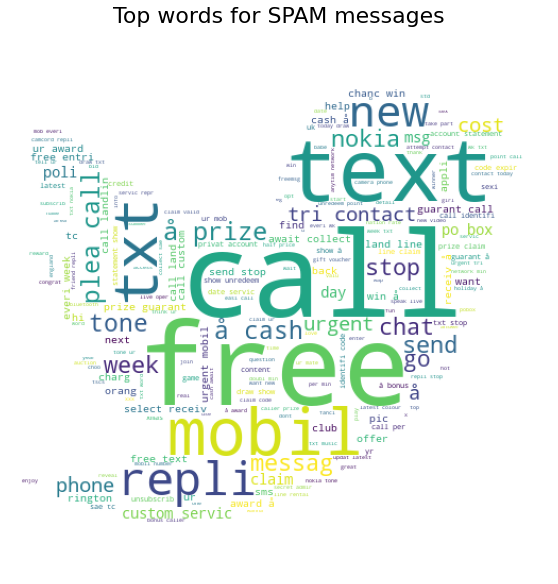

In [19]:
twitter_mask = np.array(Image.open('/kaggle/input/masksforwordclouds/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'spam', 'message_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for SPAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

<a id='5'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">5. Vectorization</p>

Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)
2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)




Each vector will have as many dimensions as there are unique words in the SMS corpus. We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message.

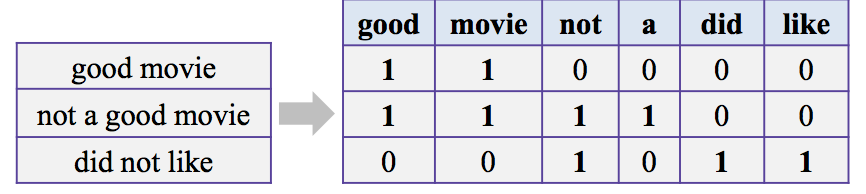

In [20]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
x = df['message_clean']
y = df['target_encoded']

print(len(x), len(y))

5572 5572


In [21]:
# Importing necessary library
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
# x: features, y: target variable
# random_state=42 ensures reproducibility of the split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

# Printing the lengths of the training and testing sets
print(len(x_train), len(y_train))  # Number of samples in the training set
print(len(x_test), len(y_test))    # Number of samples in the testing set


4179 4179
1393 1393


In [22]:
# Importing necessary library
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate the CountVectorizer object
vect = CountVectorizer()

# Fit the CountVectorizer to the training data
vect.fit(x_train)


CountVectorizer()

In [23]:
# Use the trained to create a document-term matrix from train and test sets
# Transform the training data into a document-term matrix (DTM)
x_train_dtm = vect.transform(x_train)

# Transform the testing data into a document-term matrix (DTM)
x_test_dtm = vect.transform(x_test)


<a id='5.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">5.1 Tunning CountVectorizer</p>

CountVectorizer has a few parameters you should know.

1. **stop_words**: Since CountVectorizer just counts the occurrences of each word in its vocabulary, extremely common words like ‘the’, ‘and’, etc. will become very important features while they add little meaning to the text. Your model can often be improved if you don’t take those words into account. Stop words are just a list of words you don’t want to use as features. You can set the parameter stop_words=’english’ to use a built-in list. Alternatively you can set stop_words equal to some custom list. This parameter defaults to None.

2. **ngram_range**: An n-gram is just a string of n words in a row. E.g. the sentence ‘I am Groot’ contains the 2-grams ‘I am’ and ‘am Groot’. The sentence is itself a 3-gram. Set the parameter ngram_range=(a,b) where a is the minimum and b is the maximum size of ngrams you want to include in your features. The default ngram_range is (1,1). In a recent project where I modeled job postings online, I found that including 2-grams as features boosted my model’s predictive power significantly. This makes intuitive sense; many job titles such as ‘data scientist’, ‘data engineer’, and ‘data analyst’ are 2 words long.

3. **min_df, max_df**: These are the minimum and maximum document frequencies words/n-grams must have to be used as features. If either of these parameters are set to integers, they will be used as bounds on the number of documents each feature must be in to be considered as a feature. If either is set to a float, that number will be interpreted as a frequency rather than a numerical limit. min_df defaults to 1 (int) and max_df defaults to 1.0 (float).

4. **max_features**: This parameter is pretty self-explanatory. The CountVectorizer will choose the words/features that occur most frequently to be in its’ vocabulary and drop everything else. 

You would set these parameters when initializing your CountVectorizer object as shown below.

In [24]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

<a id='5.2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">5.2 TF-IDF</p>


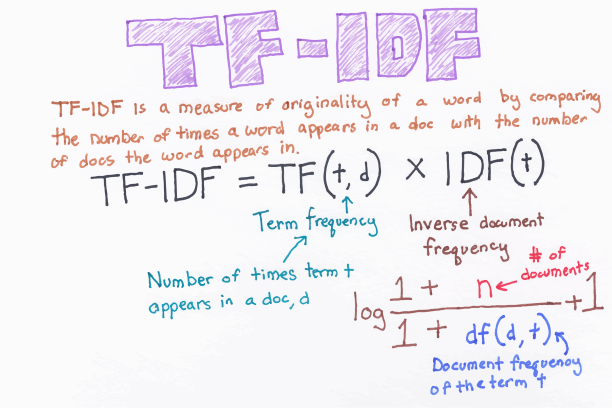

In [25]:
# Importing necessary library
from sklearn.feature_extraction.text import TfidfTransformer

# Instantiate the TfidfTransformer object
tfidf_transformer = TfidfTransformer()

# Fit the TfidfTransformer to the document-term matrix (DTM) obtained from the training data
tfidf_transformer.fit(x_train_dtm)

# Transform the training document-term matrix (DTM) to TF-IDF representation
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)


<a id='5.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">5.3 Word Embeddings: GloVe</p>



In [26]:
texts = df['message_clean']
target = df['target_encoded']

We need to perform **tokenization** - the processing of segmenting text into sentences of words. The benefit of tokenization is that it gets the text into a format that is easier to convert to raw numbers, which can actually be used for processing.

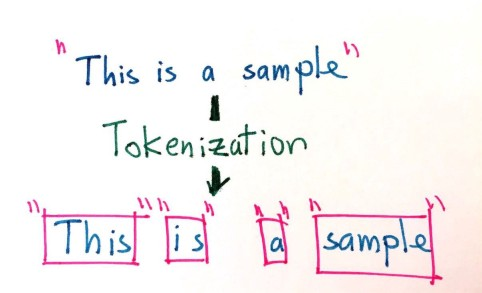

In [27]:
# Importing necessary library
from keras.preprocessing.text import Tokenizer

# Instantiate the Tokenizer object
word_tokenizer = Tokenizer()

# Fit the Tokenizer to the text data to generate vocabulary
word_tokenizer.fit_on_texts(texts)

# Calculate the length of the vocabulary
vocab_length = len(word_tokenizer.word_index) + 1


### Pad_sequences



In [28]:
# Define a function to convert text data into sequences of integers
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

# Find the longest sentence in the training data
longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))

# Calculate the length of the longest sentence
length_long_sentence = len(word_tokenize(longest_train))

# Pad all sequences to the length of the longest sentence
train_padded_sentences = pad_sequences(
    embed(texts),              # Convert text data to sequences of integers
    length_long_sentence,      # Length to pad each sequence to
    padding='post'             # Padding type: 'post' pads sequences at the end
)

# Display the padded sequences
train_padded_sentences


array([[   2, 3179,  274, ...,    0,    0,    0],
       [   8,  236,  527, ...,    0,    0,    0],
       [   9,  356,  588, ...,    0,    0,    0],
       ...,
       [6724, 1002, 6725, ...,    0,    0,    0],
       [ 138, 1251, 1603, ...,    0,    0,    0],
       [1986,  378,  170, ...,    0,    0,    0]], dtype=int32)

### GloVe

GloVe method is built on an important idea,

> You can derive semantic relationships between words from the co-occurrence matrix.


Thus when using word embeddings, all individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network.

In [29]:
# Initialize an empty dictionary to store word embeddings
embeddings_dictionary = dict()

# Define the embedding dimension
embedding_dim = 100

# Load GloVe 100D embeddings from a text file
with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt') as fp:
    # Iterate over each line in the file
    for line in fp.readlines():
        # Split the line into word and vector dimensions
        records = line.split()
        word = records[0]  # Extract the word
        # Convert vector dimensions to a NumPy array of type float32
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        # Store the word and its corresponding vector dimensions in the dictionary
        embeddings_dictionary[word] = vector_dimensions

# Display the embeddings dictionary
# embeddings_dictionary


In [30]:
# Initialize an embedding matrix with zeros
embedding_matrix = np.zeros((vocab_length, embedding_dim))

# Iterate over each word and its corresponding index in the word index dictionary
for word, index in word_tokenizer.word_index.items():
    # Retrieve the embedding vector for the word from the GloVe dictionary
    embedding_vector = embeddings_dictionary.get(word)
    # Check if the embedding vector exists for the word
    if embedding_vector is not None:
        # If the embedding vector exists, assign it to the corresponding index in the embedding matrix
        embedding_matrix[index] = embedding_vector

# Display the embedding matrix
# embedding_matrix


<a id='6'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">6. Modeling</p>

In [31]:
import plotly.figure_factory as ff

# Define the labels for the x and y axes of the heatmap
x_axes = ['Ham', 'Spam']
y_axes =  ['Spam', 'Ham']

# Define the function to create a confusion matrix heatmap
def conf_matrix(z, x=x_axes, y=y_axes):
    # Flip the matrix along the vertical axis to match the standard confusion matrix layout
    z = np.flip(z, 0)

    # Convert each element of z to a string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # Create an annotated heatmap figure using Plotly's figure factory
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # Add title and axis labels
    fig.update_layout(
        title_text='<b>Confusion matrix</b>',
        xaxis=dict(title='Predicted value'),
        yaxis=dict(title='Real value')
    )

    # Show the color scale
    fig['data'][0]['showscale'] = True
    
    return fig


In [32]:
# Create a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(x_train_dtm, y_train)

MultinomialNB()

<a id='6.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">6.1 Naive Bayes DTM</p>



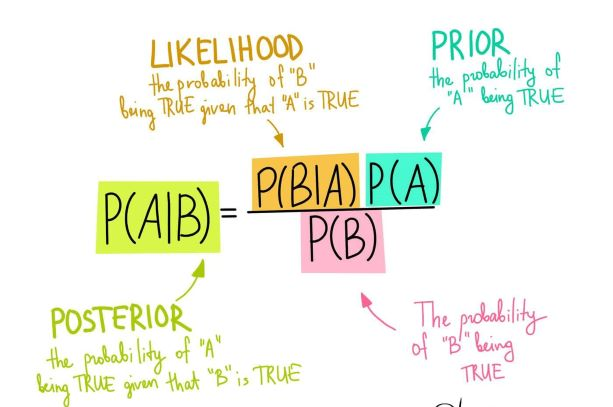

In [33]:
# Make class anf probability predictions
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

In [34]:
# calculate accuracy of class predictions
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

0.9784637473079684


In [35]:
# Calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.974296765425861

<a id='6.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">6.2 Naive Bayes</p>

In [36]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])

In [37]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

0.9597989949748744


<a id='6.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">6.3 XGBoost</p>

In [38]:
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

In [39]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

Train: 0.9834888729361091
Test: 0.9662598707824839


<a id='7'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">7. LSTM</p>

In [40]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    target, 
    test_size=0.25
)

In [41]:

def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 100)           672600    
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 160)           115840    
_________________________________________________________________
global_max_pooling1d (Global (None, 160)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 160)               640       
_________________________________________________________________
dropout (Dropout)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 80)                12880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0

In [42]:
# Load the model and train!!

model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
131/131 [==============================] - 59s 408ms/step - loss: 0.4435 - accuracy: 0.8353 - val_loss: 0.3361 - val_accuracy: 0.9383

Epoch 00001: val_loss improved from inf to 0.33608, saving model to model.h5
Epoch 2/7
131/131 [==============================] - 52s 398ms/step - loss: 0.1775 - accuracy: 0.9432 - val_loss: 0.1607 - val_accuracy: 0.9620

Epoch 00002: val_loss improved from 0.33608 to 0.16068, saving model to model.h5
Epoch 3/7
131/131 [==============================] - 51s 393ms/step - loss: 0.1272 - accuracy: 0.9606 - val_loss: 0.1051 - val_accuracy: 0.9734

Epoch 00003: val_loss improved from 0.16068 to 0.10506, saving model to model.h5
Epoch 4/7
131/131 [==============================] - 52s 399ms/step - loss: 0.1050 - accuracy: 0.9708 - val_loss: 0.2253 - val_accuracy: 0.9146

Epoch 00004: val_loss did not improve from 0.10506
Epoch 5/7
131/131 [==============================] - 52s 398ms/step - loss: 0.0814 - accuracy: 0.9763 - val_loss: 0.1747 - val_acc

### Lets see the results

In [43]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

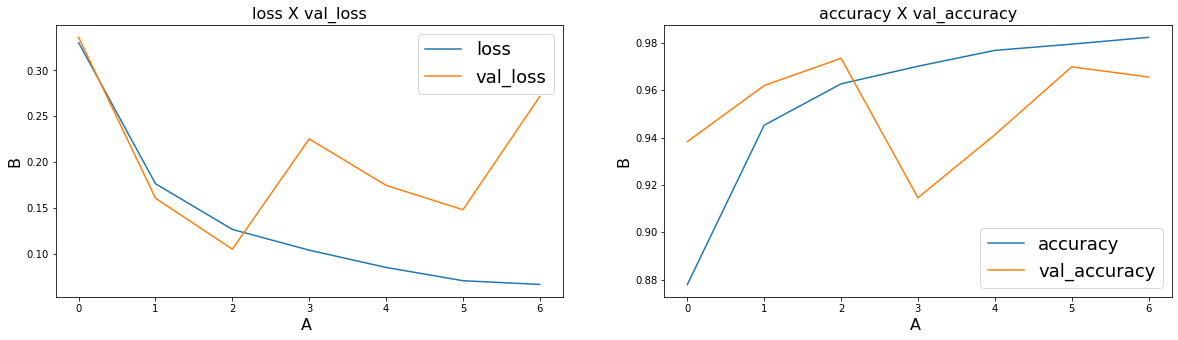

In [44]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [45]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix(metrics.confusion_matrix(y_test, y_preds))

<a id='8'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">8. BERT</p>

BERT (Bidirectional Encoder Representations from Transformers) is a recent paper published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), and others.




In [46]:
# install transformers
!pip install transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [48]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
except:
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

Number of replicas in sync:  1


In [49]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [50]:
texts = df['message_clean']
target = df['target_encoded']

train_input_ids, train_attention_masks = bert_encode(texts,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2142: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [51]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [52]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [53]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 32)           24608       tf_bert_model[0][1]          

In [54]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2, 
    epochs=3,
    batch_size=10
)

Epoch 1/3
446/446 [==============================] - 88s 164ms/step - loss: 0.2373 - accuracy: 0.9116 - val_loss: 0.0750 - val_accuracy: 0.9740
Epoch 2/3
446/446 [==============================] - 70s 157ms/step - loss: 0.0678 - accuracy: 0.9832 - val_loss: 0.0546 - val_accuracy: 0.9830
Epoch 3/3
446/446 [==============================] - 70s 158ms/step - loss: 0.0340 - accuracy: 0.9920 - val_loss: 0.0513 - val_accuracy: 0.9848


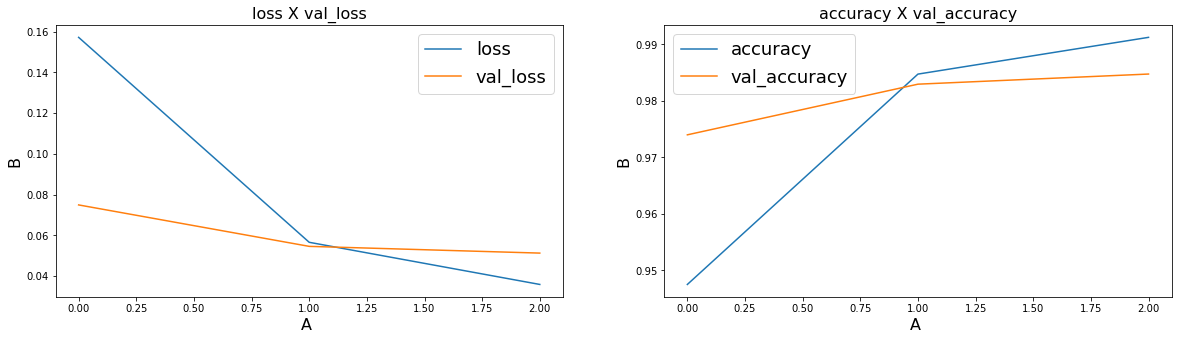

In [55]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])